In [1]:
import copy
import pathlib
import pickle

from astropy.stats import median_absolute_deviation as MAD
import astropy.table as at
import astropy.units as u
import jax
import matplotlib as mpl
import matplotlib.pyplot as plt
import gala.potential as gp
import gala.integrate as gi
import numpy as np
from gala.units import galactic
import jax.numpy as jnp
from scipy.stats import binned_statistic, binned_statistic_2d

import torusimaging as oti
from torusimaging_helpers.plot import (
    plot_bdata,
    plot_data_model_residual,
    plot_spline_functions,
    plot_az_Jz,
    plot_orbit_shapes,
)
from torusimaging_helpers.config import gala_pot, agama_pot, R0, vc0
from torusimaging_helpers.make_sim_data import make_qiso_df
import agama

jax.config.update("jax_enable_x64", True)

In [2]:
cache_path = pathlib.Path("../cache").resolve()
cache_path.mkdir(exist_ok=True)

In [83]:
pdata = make_qiso_df(N=1_000_000)

# pdata_file = cache_path / "qiso-pdata.hdf5"
# pdata.write(pdata_file, overwrite=True, serialize_meta=True)

/Users/aprice-whelan/projects/scratch/.venv/lib/python3.12/site-packages/numpy/lib/_polynomial_impl.py:778: RuntimeWarning: overflow encountered in multiply
  y = y * x + pv
/Users/aprice-whelan/projects/torusimaging-radial/scripts/torusimaging_helpers/make_sim_data.py:107: RuntimeWarning: overflow encountered in exp
  sigma_r = sigma_r0 * np.exp((R0 - R_c) / R_sigma)
/Users/aprice-whelan/projects/torusimaging-radial/scripts/torusimaging_helpers/make_sim_data.py:108: RuntimeWarning: overflow encountered in exp
  sigma_z = sigma_z0 * np.exp((R0 - R_c) / R_sigma)
/Users/aprice-whelan/projects/torusimaging-radial/scripts/torusimaging_helpers/make_sim_data.py:111: RuntimeWarning: overflow encountered in exp
  Sigma_term = A * np.exp(-R_c / R_d)
/Users/aprice-whelan/projects/torusimaging-radial/scripts/torusimaging_helpers/make_sim_data.py:111: RuntimeWarning: invalid value encountered in multiply
  Sigma_term = A * np.exp(-R_c / R_d)
/Users/aprice-whelan/projects/torusimaging-radial/script

In [138]:
Rg = pdata["Rg"]
vc = vc0

# TODO: hack - what if we get the rotation curve wrong?
# vc = 220 * u.km/u.s
# Rg = (pdata["J"][:, 1] / vc).to(u.kpc)

In [139]:
Rg_bin = 8.0 * u.kpc
mask = (np.abs(Rg - Rg_bin) < 0.5 * u.kpc) & (pdata["zmax"] < 0.1 * u.kpc)
mask.sum()

np.int64(129023)

Bin by guiding radius:

In [140]:
pdata_bin = pdata[mask].copy()
pdata_bin["x_R"] = pdata_bin["R"] - Rg[mask]

In [141]:
def make_mgfe(JR, slope=0.1 / 10, std=0.05, rng=None):
    """
    Default parameters from APOGEE in fiducial model
    """
    if rng is None:
        rng = np.random.default_rng()

    x = np.sqrt(JR)
    mgfe = slope * x + 0.0
    mgfe = rng.normal(mgfe, std)
    mgfe_err = np.exp(rng.normal(-4.0, 0.5, size=len(JR)))
    mgfe = rng.normal(mgfe, mgfe_err)
    return mgfe, mgfe_err

In [142]:
pdata_bin["mgfe"], pdata_bin["mgfe_err"] = make_mgfe(
    pdata_bin["J"][:, 0].to_value(u.km / u.s * u.kpc)
)

In [143]:
tmp = np.nanpercentile(pdata_bin["x_R"].to(u.kpc), [1, 50, 99])
xtmp = np.diff(tmp)
max_v = 2 * np.nanpercentile(pdata_bin["v_R"].to(u.km / u.s), 99)

xv_bins = {
    "pos": np.linspace(-2 * xtmp[0], 2 * xtmp[1], 101),
    "vel": np.linspace(-max_v, max_v, 101),
}

bdata = oti.data.get_binned_label(
    pdata_bin["x_R"],
    pdata_bin["v_R"],
    label=pdata_bin["mgfe"],
    label_err=pdata_bin["mgfe_err"],
    bins=xv_bins,
    units=galactic,
)

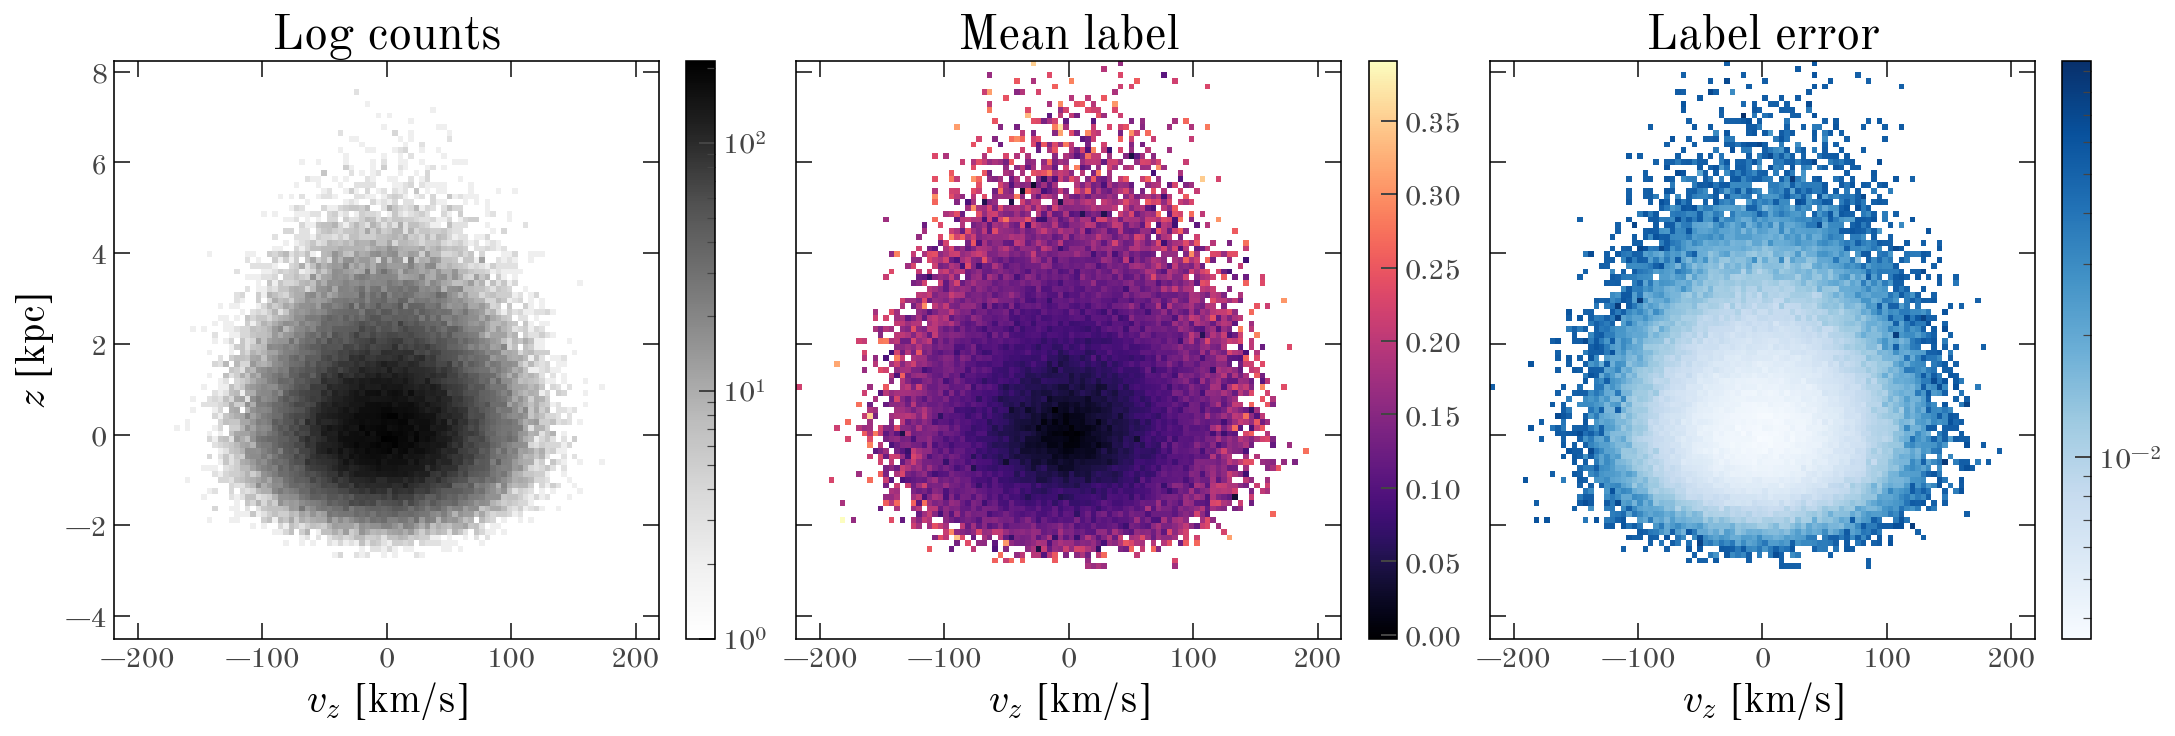

In [144]:
_ = plot_bdata(bdata)

In [145]:
model, bounds, init_params = oti.TorusImaging1DSpline.auto_init(
    bdata,
    label_knots=8,
    e_knots={1: 8, 2: 12, 3: 4, 4: 4},
    label_l2_sigma=1.0,
    label_smooth_sigma=0.5,
    e_l2_sigmas={1: 1.0, 2: 1.0, 3: 1.0, 4: 1.0},
    e_signs={1: -1, 3: -1},
    e_smooth_sigmas={1: 0.1, 2: 0.1, 3: 0.1, 4: 0.1},
    dacc_strength=0.0,
    label_knots_spacing_power=0.75,
    e_knots_spacing_power=0.5,
)

init_params["e_params"][1]["vals"] = np.full_like(
    init_params["e_params"][1]["vals"], np.log(0.05 / model._label_knots.max())
)
init_params["e_params"][2]["vals"] = np.full_like(
    init_params["e_params"][2]["vals"], -0.5
)
init_params["e_params"][3]["vals"] = np.full_like(
    init_params["e_params"][3]["vals"], np.log(0.05 / model._label_knots.max())
)
init_params["e_params"][4]["vals"] = np.full_like(
    init_params["e_params"][4]["vals"], np.log(0.05 / model._label_knots.max())
)


In [146]:
data_kw = dict(
    pos=bdata["pos"],
    vel=bdata["vel"],
    label=bdata["label"],
    label_err=bdata["label_err"],
)
data_mask = (
    np.isfinite(bdata["label"])
    & np.isfinite(bdata["label_err"])
    & (bdata["label_err"] > 0)
)
data_kw = {k: v[data_mask] for k, v in data_kw.items()}

In [147]:
test_val = model.objective_gaussian(init_params, **data_kw)
print(f"Test evaluation of objective function: {test_val}")

Test evaluation of objective function: 5.612543865384381


In [148]:
res = model.optimize(init_params, objective="gaussian", bounds=bounds, **data_kw)

In [149]:
params = copy.deepcopy(res.params)
# params["e_params"][3]["vals"] = jnp.full_like(params["e_params"][3]["vals"], -1.0)

res.params

{'e_params': {1: {'vals': Array([-0.85034643, -0.8659874 , -0.91414436, -1.00806914, -1.15263091,
          -1.24429169, -1.29913365], dtype=float64)},
  2: {'vals': Array([-2.2796936 , -2.27795675, -2.27318539, -2.26552536, -2.248243  ,
          -2.20226283, -2.12599858, -2.0549627 , -2.00526867, -1.96964381,
          -1.9459879 ], dtype=float64)},
  3: {'vals': Array([-2.16475892, -2.20661779, -2.2336161 ], dtype=float64)},
  4: {'vals': Array([-16., -16., -16.], dtype=float64)}},
 'label_params': {'label_vals': Array([-0.00125158,  0.23445931,  0.23617382,  0.24535747,  0.30277736,
          0.28359726,  0.14701043,  0.10663823], dtype=float64)},
 'ln_Omega0': Array(-3.22164839, dtype=float64),
 'pos0': Array(-0.00925676, dtype=float64),
 'vel0': Array(-0.0002657, dtype=float64)}

The "corrected" vc is the true vc, so that's cool!

In [150]:
vc + -vc * params["pos0"]*u.kpc / Rg_bin

<Quantity 229.26497469 km / s>

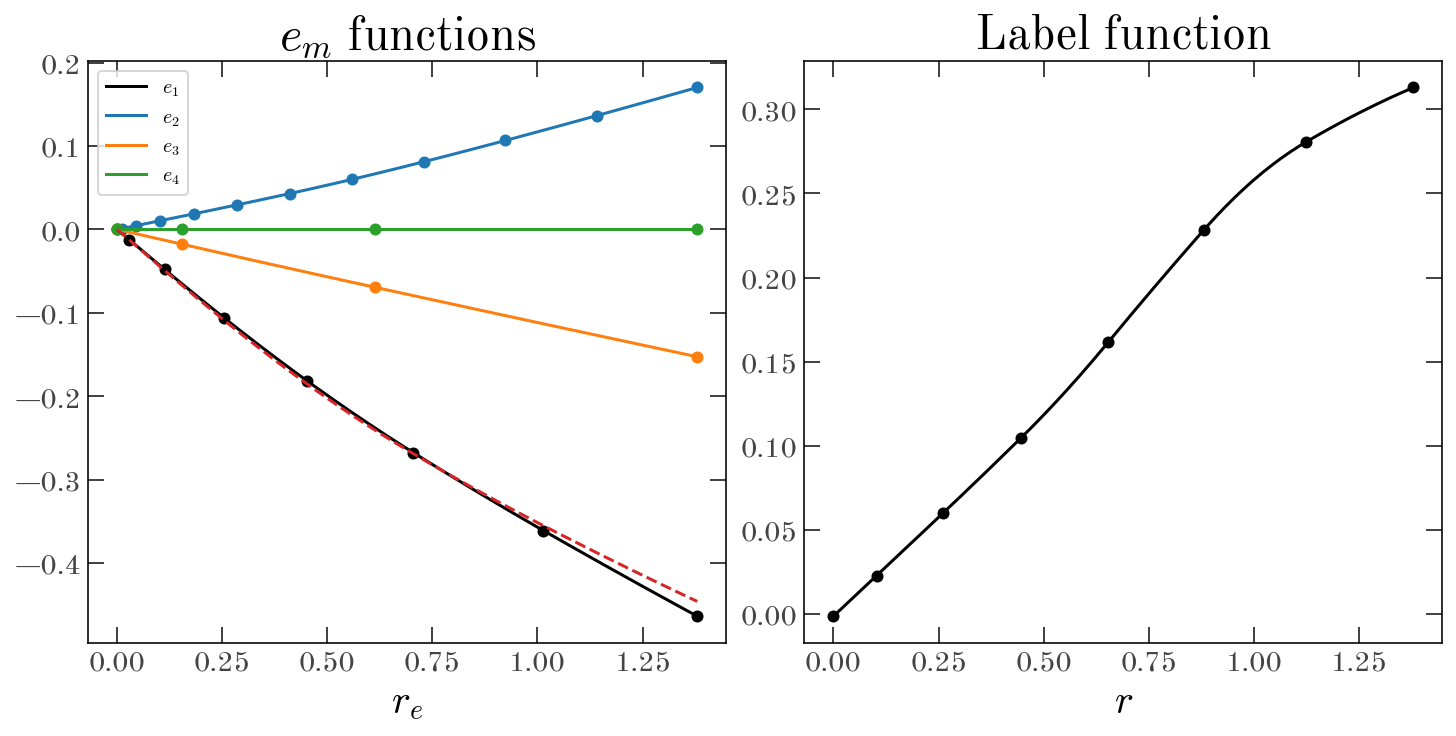

In [151]:
_ = plot_spline_functions(model, params)

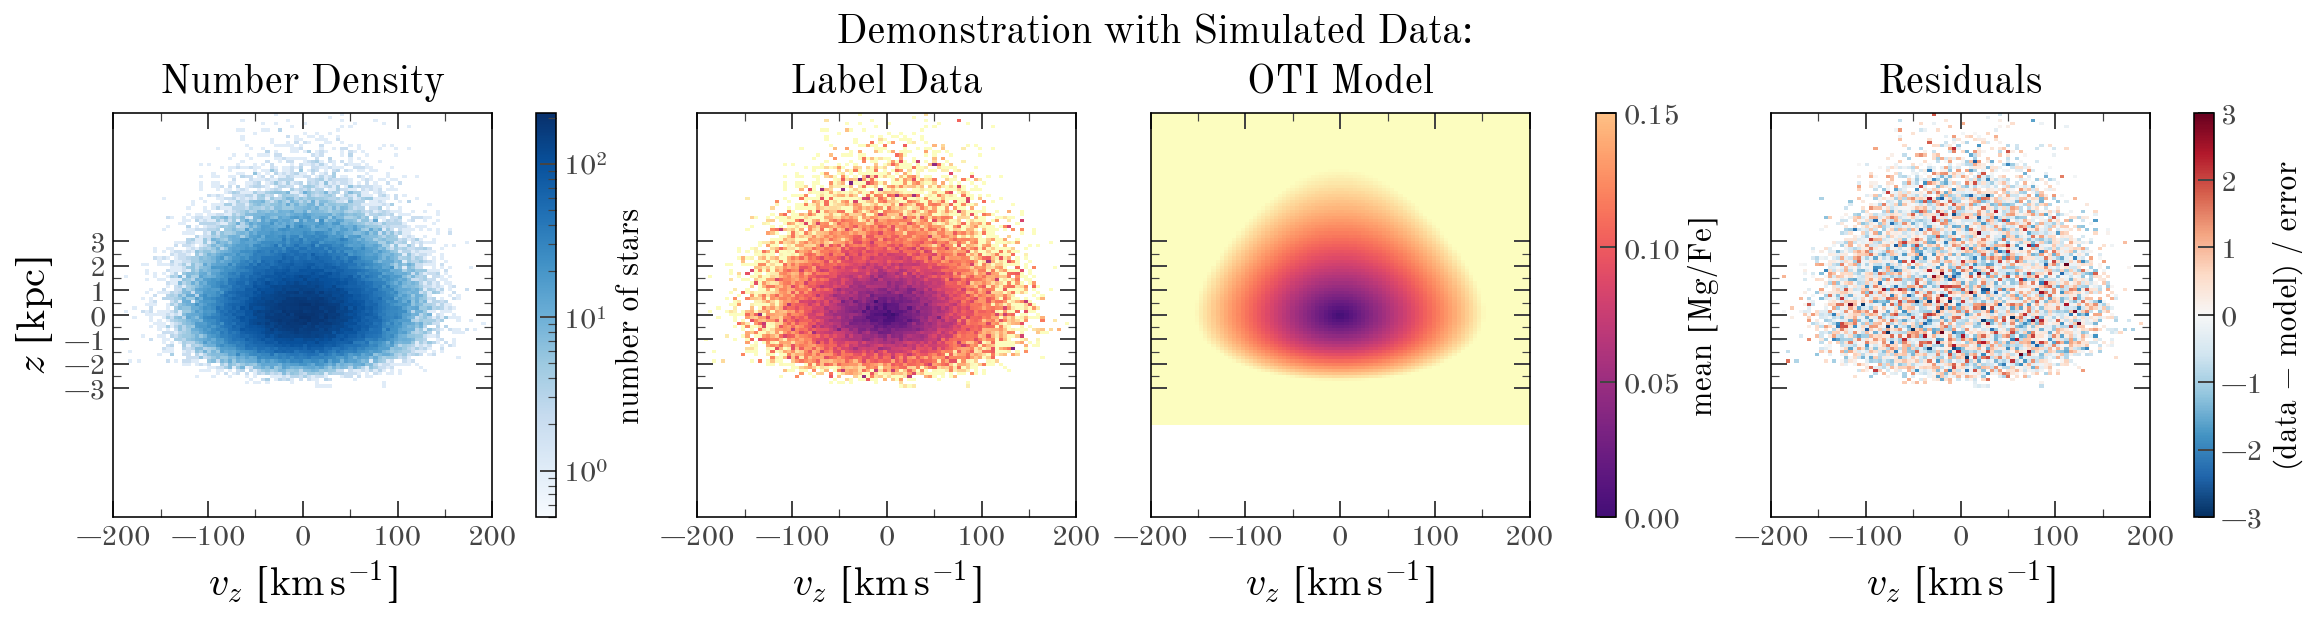

In [152]:
fig, axes = plot_data_model_residual(
    model,
    bdata,
    params,
    zlim=2 * xtmp[1],
    vzlim=200 * u.km / u.s,
    aspect=False,
    suptitle2="",
)

In [153]:
a_unit = u.km / u.s / u.Myr
# x_grid = np.linspace(-3, 6, 1024) * u.kpc
x_grid = np.zeros(1) * u.kpc
bestfit_aR = model.get_acceleration(x_grid, params).to(a_unit)

# WTF: complex??? real or abs?? or something is fucked in get_acceleration for R case
# TODO: need to iterate, because vc assumed...??
dPhi_dR = -bestfit_aR.real + (Rg_bin * vc) ** 2 / (Rg_bin + x_grid) ** 3
# dPhi_dR = np.sqrt(bestfit_aR.real**2 + bestfit_aR.imag**2) + (Rg_bin * vc0) ** 2 / (Rg_bin + x_grid) ** 3

In [154]:
true_dPhi_dR = gala_pot.gradient(
    np.array([1.0, 0, 0])[:, None] * (Rg_bin + x_grid[None])
)[0]

In [155]:
np.sqrt(Rg_bin * true_dPhi_dR).to_value(u.km/u.s)

array([229.46880577])

In [156]:
np.sqrt(Rg_bin * dPhi_dR).to_value(u.km/u.s)

array([229.24565507])

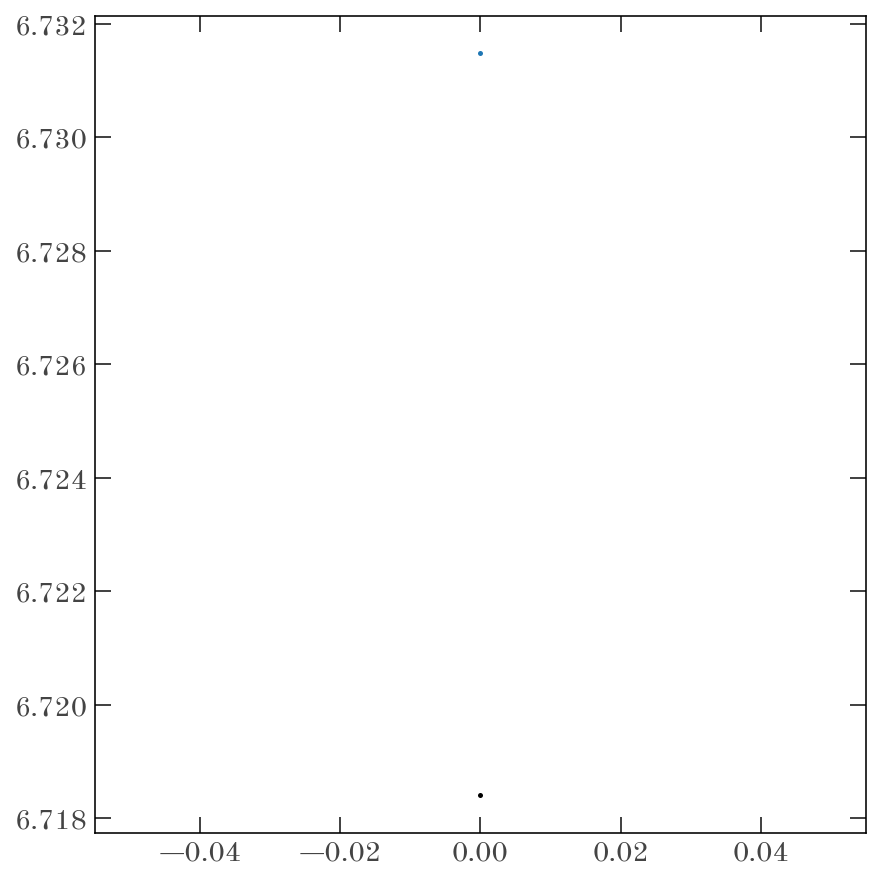

In [157]:
plt.plot(x_grid.value, dPhi_dR.to_value(a_unit))
plt.plot(x_grid.value, true_dPhi_dR.to_value(a_unit))
# plt.plot(x_grid.value, bestfit_acc.value)
# plt.plot(x_grid.value, true_acc.value)